In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [139]:
def act_hill(inputs):
    x = np.sum(inputs)
    k = 0.5
    n = 2
    return (x**n)/(x**n + k**n)

def inib_hill(inputs):
    x = np.sum(inputs)
    k = 0.5
    n = 2
    return (k**n)/(x**n + k**n)

In [27]:
def MNIST_load():
    from keras.datasets import mnist
    (X, y), (_, _ )= mnist.load_data()
    X = X.astype(np.float32) / 255.0
    y = y.astype(np.int32)
    return X, y

def one_hot_encode(y):
    num_classes = np.unique(y).shape[0]
    y_one_hot = np.zeros((y.shape[0], num_classes), dtype=int)
    y_one_hot[np.arange(y.shape[0]), y] = 1
    return y_one_hot

def train_test_split(X, y, split_ratio = 0.7):
    N = X.shape[0]
    rnd_idx = np.random.permutation(N)
    train_idx = rnd_idx[:int(split_ratio * X.shape[0])]
    test_idx = rnd_idx[int(split_ratio * X.shape[0]):]
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    return X_train, y_train, X_test, y_test

In [28]:
X, y = MNIST_load()

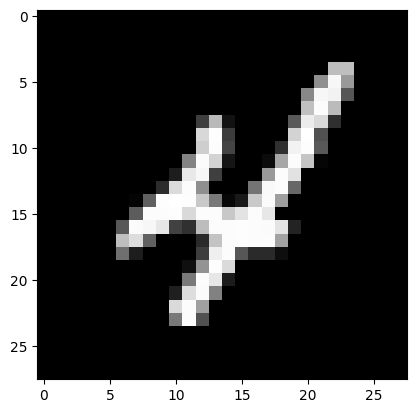

In [113]:
plt.imshow(X[9], cmap = "gray")

Finished!


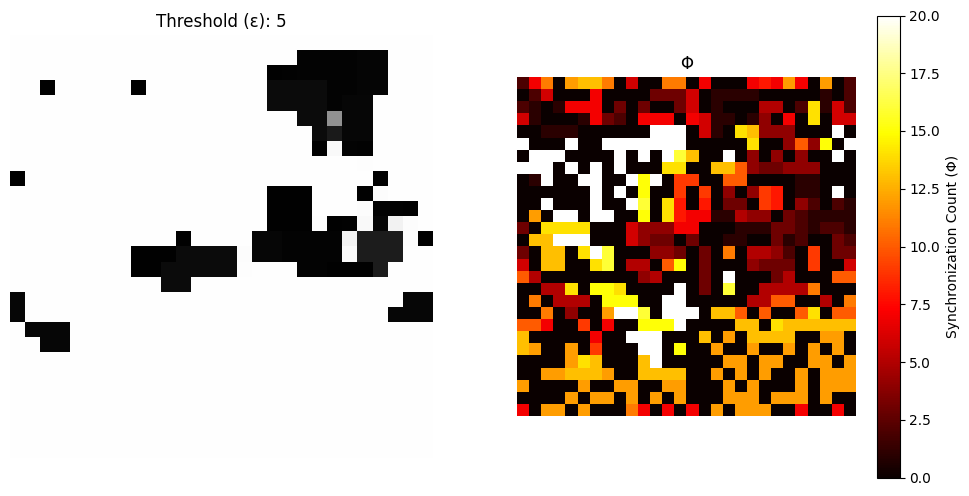

In [140]:
gates = [act_hill, inib_hill]
N = X[0].shape[0]
gate = np.random.choice(gates, (N, N))
S = X[9]
ϵ = 5
Φ = np.zeros((N, N), dtype = int)
N_iter = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mat1 = ax1.imshow(S, cmap="gray", vmin=0, vmax=1)
mat2 = ax2.imshow(Φ, cmap="hot", vmin=0, vmax=N_iter)
ax1.set_title(f"Threshold (ε): {ε}")
ax1.axis("off")
ax2.set_title("Φ")
ax2.axis("off")
cbar2 = fig.colorbar(mat2, ax=ax2)
cbar2.set_label("Synchronization Count (Φ)")

def update(*args):
    global S, Φ, ϵ, gate


    if np.mean(Φ) >= ϵ:
        gate = np.random.choice(gates, (N, N))

    #Getting neighbors by shifting matrix
    left = np.roll(S, -1, axis = 1)
    right = np.roll(S, 1, axis = 1)
    up = np.roll(S, 1, axis = 0)
    down = np.roll(S, -1, axis = 0)
    upper_left = np.roll(np.roll(S, 1, axis = 0), -1, axis = 1)
    upper_right = np.roll(np.roll(S, 1, axis = 0), 1, axis = 1)
    bottom_left = np.roll(np.roll(S, -1, axis = 0), -1, axis = 1)
    bottom_right = np.roll(np.roll(S, -1, axis = 0), 1, axis = 1)

    # stack neighbor states
    neighbors = np.stack([left, right, up, down, upper_left,
     upper_right, bottom_left, bottom_right], axis = 0)
    
    new_state = np.array([[gate[i, j](neighbors[:, i, j]) for j in range(N)] for i in range(N)])

    sync = (np.where(new_state > 0.5, 1, 0) == np.where(S > 0.5, 1, 0))
    Φ[sync] += 1 
    Φ[~sync] = 0
    mask_ensemble = (Φ >= ε)
    S = new_state
    if np.any(mask_ensemble):
        ensemble_idxs = np.argwhere(mask_ensemble)
        for i, j in ensemble_idxs:
        	#update neighbors given central neuron forming ensemble
            S[(i-1) % N, (j-1) % N] = S[i, j]  #upper left 
            S[(i-1) % N, (j+1) % N] = S[i, j]  #upper right 
            S[(i+1) % N, (j+1) % N] = S[i, j]  #bottom right 
            S[(i+1) % N, (j-1) % N] = S[i, j]  #bottom left
            S[i, (j-1) % N] = S[i, j]  #left 
            S[i, (j+1) % N] = S[i, j]  #right 
            S[(i-1) % N, j] = S[i, j]  #up 
            S[(i+1) % N, j] = S[i, j]  #down 

    mat1.set_array(S)
    mat2.set_array(Φ)
    ax1.set_title(f"Threshold (ε): {ε}")
    return mat1, mat2

ani = FuncAnimation(fig, update, frames=N_iter, interval=1000)
ani.save("autopoietic_net.gif", writer="pillow", fps=10)
print("Finished!")
#plt.show()

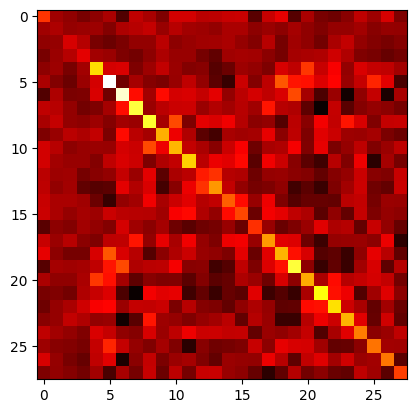

In [141]:
plt.imshow(np.cov(Φ), cmap = "hot")